In [1]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat
import time

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

reload(ParticleFilter)
reload(Poisson_Tree_Particle_Filter)

from numpy.random import choice, poisson, gamma, normal
from scipy.stats import norm
from scipy.stats import bernoulli, gamma

from Tree_Node import *

In [2]:
seed = 17 

# Generate data

In [3]:
def get_s_1(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return s_0 + v_0*dt + (1/2)*a_0*(dt**2)

def get_v_1(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return v_0 + a_0*dt

In [4]:
def generate_data(n_res, res, sigma_theta, s_x_0, v_x_0, s_y_0, v_y_0, gamma_shape=2, gamma_scale=1, seed=0):
    np.random.seed(seed)
    
    #generate tau
    tau = [0]
    
    while tau[-1] < n_res*res:
        tau.append(tau[-1] + np.random.gamma(shape=gamma_shape, scale=gamma_scale))

    _ = tau.pop()
    tau = np.array(tau)
    kT = len(tau)
    
    #generate acceleration at tau
    a_x_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
    a_y_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
           
    #compute states variables at tau
    s_x_tau, v_x_tau, = np.empty(kT), np.empty(kT)
    s_y_tau, v_y_tau, = np.empty(kT), np.empty(kT)
        
    s_x_tau[0], v_x_tau[0] = s_x_0, v_x_0
    s_y_tau[0], v_y_tau[0] = s_y_0, v_y_0
    
    for i1 in range(1, kT):
        i0 = i1 - 1
        s_x_tau[i1] = get_s_1(
            s_0=s_x_tau[i0],
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        s_y_tau[i1] = get_s_1(
            s_0=s_y_tau[i0],
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_x_tau[i1] = get_v_1(
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_y_tau[i1] = get_v_1(
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
    
    
    #compute path/trajectory
    s_x, s_y = np.empty(n_res+1), np.empty(n_res+1)
    
    s_x[0], s_y[0] = s_x_0, s_y_0
    
    tau_index = 0
    for i in range(1, n_res+1):
        t = i*res
        
        #find last tau before this t
        while t > tau[tau_index]:
            tau_index += 1
        
            if tau_index == kT:
                break
            
        tau_index -= 1
        
        #compute coordinates at t
        s_x[i] = get_s_1(
            s_0=s_x_tau[tau_index],
            v_0=v_x_tau[tau_index],
            a_0=a_x_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
        s_y[i] = get_s_1(
            s_0=s_y_tau[tau_index],
            v_0=v_y_tau[tau_index],
            a_0=a_y_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
                
    return s_x_tau, s_y_tau, s_x, s_y, tau

In [5]:
def generate_observations(delta_t, res, mean, std, x, y):   
    step = int(delta_t / res)
    x_noisy, y_noisy = x[::step] + np.random.normal(mean, std, x[::step].size), y[::step] + np.random.normal(mean, std, y[::step].size)
    
    return x_noisy, y_noisy

In [6]:
#%%script false --no-raise-error

T = 200
delta_t = 5
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 5.0
sigma_obs = 200.0

gamma_shape = 10.0
gamma_scale = 2.5

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)
print(lam)

s_x_0, s_y_0 = 64000, 29000
v_x_0, v_y_0 = 400, 0

0.2


In [7]:
s_x_tau, s_y_tau, s_x, s_y, tau= generate_data(
    n_res,
    res,
    sigma_theta,
    s_x_0=s_x_0,
    s_y_0=s_y_0,
    v_x_0=v_x_0,
    v_y_0=v_y_0,
    gamma_shape=gamma_shape,
    gamma_scale=gamma_scale,
    seed=seed
)

x_obs, y_obs = generate_observations(delta_t, res, mean=0.0, std=sigma_obs, x=s_x, y=s_y)

# Generate algorithm

In [8]:
num_particles = 100
num_theta = 50
sigma_obs = 500

gamma_shape = gamma_shape 
gamma_scale = gamma_scale 

sigma_theta = sigma_theta 

x_obs, y_obs = np.insert(x_obs, 0, 64000), np.insert(y_obs, 0, 29000)
step = int(delta_t / res)

#for i in [5, 15, 25, 35]:
#    x_obs[i] = s_x[::step][i] + normal(0, 2500)
#    y_obs[i] = s_y[::step][i] + normal(0, 2500)
#

In [9]:
sigma_adjust = delta_t / 1000
capacity = n*3
weights = np.ones(num_particles)
log_weights = np.zeros(num_particles)
store_weights = np.zeros([num_particles, n + 2])

particles =  []

capacity = 500
expectation_x,  expectation_y = np.zeros(n + 2), np.zeros(n + 2)

num_unique_particles_pre = np.zeros(n + 2)
num_unique_particles_post = np.zeros(n + 2)
x_temp, y_temp = np.zeros([num_particles, n + 2]), np.zeros([num_particles, n + 2])
ess = np.zeros(n + 2)

In [10]:
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0 * dt + (1 / 2) * a_0 * (dt ** 2)

def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0 * dt

def get_temporary_position(j, current_t, particles, delta_t):
    x_temp = get_space(particles[current_t][j].get_sx(), particles[current_t][j].get_vx(), particles[current_t][j].get_ax(), particles[current_t][j].get_tau(), current_t * delta_t)
    y_temp = get_space(particles[current_t][j].get_sy(), particles[current_t][j].get_vy(), particles[current_t][j].get_ay(), particles[current_t][j].get_tau(), current_t * delta_t)
    return x_temp, y_temp
    

def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x * pobsy_given_y

def logLikelihood(x, mu, sigma):
    return - (1 / 2) * np.log(2*np.pi) - (1 / 2) * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * (x - mu)**2

def log_weights(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    loglikelihood_x = logLikelihood(x_temp, x_obs, sigma_obs)
    loglikelihood_y = logLikelihood(y_temp, y_obs, sigma_obs)
    return loglikelihood_x + loglikelihood_y
    
def init_particles(lam, num_particles, delta_t, particles, sigma_theta):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta) 
        tau =  0
        particles[0].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 1))
    return particles


                        
def multiple_birth_move(current_t, j, particles, sigma_theta):
    k_new = 1
    #k_new = 2*np.ones(n)
    
    #ts = particles(j,tau,k(j)) + delta_t*rand(1,k_new(j));
  
    tau = particles[current_t - 1][j].get_tau() + ((current_t) * delta_t - particles[current_t - 1][j].get_tau())*np.random.uniform(0, 1, k_new)
 
    ax = np.random.normal(0, sigma_theta)
    ay = np.random.normal(0, sigma_theta)
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
    
    
def resample(current_t, weights, num_particles):
    
    M = len(weights)
    
    ni = np.random.permutation(M)
    weights = weights[ni]
    
    inds = np.zeros(num_particles)
    
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    
    cdf[-1] = 1
    
    p = np.linspace(np.random.uniform(0, 1) * (1 / num_particles), 1, num_particles)
    picked = np.zeros(M)
                    
    j=0
    for i in range(num_particles):
        while (j < M) & (cdf[j] < p[i]):
            j += 1
        picked[j] += 1
    
    rind = 0
    for i in range(M):
        if picked[i] > 0:
            for j in range(int(picked[i])):
                inds[rind] = int(ni[i])
                rind = rind + 1
                
    return inds.astype(int)

def adjust_move(current_t, j, particles, sigma_adjust):
    #new tau
    tau = -1
    while tau < 0:
        tau = np.random.normal(particles[current_t - 1][j].get_tau(), sigma_adjust)
    if tau <= 0:
        print(tau, j, t, 'adjust')
    #evaluate x and v in the new tau
    ax = particles[current_t - 1][j].get_ax()
    ay = particles[current_t - 1][j].get_ay()
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    
    if current_t == 1:
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None)
    else :
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 2][j])
    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
                    

def compute_survivor_probability(current_t, num_particles, delta_t, particles, gamma_shape, gamma_scale):
    p = np.zeros(num_particles)
    
    for j in range(num_particles):
        p[j] = gamma.cdf(current_t* delta_t - particles[current_t - 1][j].get_tau(), gamma_shape, gamma_scale) - gamma.cdf(0, gamma_shape, gamma_scale)
            
        if  np.isnan(p[j]):
            print(p[j], current_t)
            print(gamma_shape, gamma_scale)

        
    S = np.ones(num_particles) - p
    
    return S
    
 

In [11]:
def PF_step(particles, weights, x_temp, y_temp, alpha, num_particles, S):
    particles.append([])
    
    for j in range(num_particles):
        
        if alpha[j] == 1:
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
        
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs) 
            
            particles = adjust_move(t, j, particles, sigma_adjust)
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
                                                                                                       
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))
            
            #if (prev_likelihood * S[j] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            #else:
            #    weights[j] = (curr_likelihood * 1/2)
        
        else:
                
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
            
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            particles = multiple_birth_move(t, j, particles, sigma_theta)
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
            
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))

            #if (prev_likelihood * (1 - S[j]) != 0) and ((t+1) * delta_t - particles['tau'][j, k[j]-1] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
            #else:
            #    weights[j] = curr_likelihood * 1 / 2
    #print(particles['tau'][:, k[9]])
    
    return particles, weights, x_temp, y_temp

In [12]:
def compute_Z(num_particles, stored_weights, t_final):
    return ((1 / num_particles) ** t_final) *  np.prod(np.sum(stored_weights, 0))

def get_mean_shape(num_theta, shape_weights, shape_values):
    return (1 / np.sum(shape_weights)) * np.matmul(shape_weights, shape_values)

def get_var_shape(num_theta, shape_weights, shape_values):
    return
    
def get_mean_scale(num_theta, scale_weights, scale_values):
    return (1 / np.sum(shape_weights)) * np.matmul(scale_weights, scale_values)

def get_var_scale(num_theta, scale_weights, scale_values):
    return 
    

def PMCMC_kernel(t_final, particles, stored_weights, gamma_shape_old, gamma_scale_old, lam, gamma_shape_mean, gamma_shape_variance, gamma_scale_mean, gamma_scale_variance, num_particles, delta_t, sigma_theta):
    gamma_shape_new =max(np.random.normal(gamma_shape_old, gamma_shape_variance / 2), 1)
    gamma_scale_new =max(np.random.normal(gamma_scale_old, gamma_scale_variance / 2), 1)
    
    particles_new = []
    weights_new = np.ones(num_particles)
    x_temp_new, y_temp_new = np.zeros([num_particles, t_final + 1]), np.zeros([num_particles, t_final + 1])
    store_weights_new = np.zeros([num_particles, t_final + 1])
    
    particles_new.append([])
    particles_new = init_particles(lam, num_particles, delta_t, particles_new, sigma_theta)

    for t in range(1, t_final + 1):
    
        if t == 1:
            alpha = np.zeros(num_particles)
            S = np.zeros(num_particles)
        else:
            S = compute_survivor_probability(t, num_particles, delta_t, particles_new, gamma_shape_new, gamma_scale_new)
            alpha = np.random.binomial(1, S, size = num_particles)
            
        particles_new, weights_new, x_temp_new, y_temp_new = PF_step(particles, weights_new, x_temp_new, y_temp_new, alpha, num_particles, S)
        store_weights_new[:, t] = weights_new
            
    Z_new = compute_Z(num_particles, store_weights_new, t_final)
    Z_old = compute_Z(num_particles, stored_weights, t_final)
    
    prior_scale_new, prior_scale_old = norm.pdf(gamma_scale_mean, gamma_scale_variance), norm.pdf(gamma_scale_mean, gamma_scale_variance)
    prior_shape_new, prior_shape_old = norm.pdf(gamma_shape_mean, gamma_shape_variance), norm.pdf(gamma_shape_mean, gamma_shape_variance)
    
    T_shape_new, T_shape_old = norm.pdf(gamma_scale_old, gamma_scale_variance / 2), norm.pdf(gamma_scale_new, gamma_scale_variance / 2)
    T_scale_new, T_scale_old = norm.pdf(gamma_shape_old, gamma_shape_variance / 2), norm.pdf(gamma_shape_new, gamma_shape_variance / 2)
    
    #print((prior_scale_new * Z_new *  T_scale_new) / (prior_scale_old * Z_old *  T_scale_old))
    #print((prior_shape_new * Z_new *  T_shape_new) / (prior_shape_old * Z_old *  T_shape_old))
    
    if  (prior_scale_old * Z_old *  T_scale_old) != 0:
        acc_prob_scale = min(1, (prior_scale_new * Z_new *  T_scale_new) / (prior_scale_old * Z_old *  T_scale_old))
    else:
        acc_prob_scale = 1
    if (prior_shape_old * Z_old *  T_shape_old) != 0:
        acc_prob_shape = min(1, (prior_shape_new * Z_new *  T_shape_new) / (prior_shape_old * Z_old *  T_shape_old))
    else:
        acc_prob_shape = 1
    
    U_shape, U_scale = np.random.uniform(), np.random.uniform()
    
    if U_shape < acc_prob_shape:
        gamma_shape_updated = gamma_shape_new
    else:
        gamma_shape_updated = gamma_shape_old
        
    if U_scale < acc_prob_scale:
        gamma_scale_updated = gamma_scale_new
    else:
        gamma_scale_updated = gamma_scale_old
        
    return gamma_shape_updated, gamma_scale_updated, particles_new, x_temp_new, y_temp_new, store_weights_new, weights_new

In [13]:
np.random.seed(11)

In [14]:
store_alpha = []

In [15]:
gamma_shape_mean = 20.0 
gamma_scale_mean = 10

gamma_shape_variance = 10.0
gamma_scale_variance = 10.0

gamma_shape_list = []
gamma_shape_list = []


In [16]:
%%time

gamma_shape_values, gamma_scale_values = [], []

for N_t in range(num_theta):
    gamma_shape = max(np.random.normal(gamma_shape_mean, gamma_shape_variance), 1)
    gamma_scale = max(np.random.normal(gamma_scale_mean, gamma_scale_variance), 1)
    particles.append([])
    particles[N_t].append([])
    particles[N_t] = init_particles(lam, num_particles, delta_t, particles[N_t], sigma_theta)
    for t in range(1, n + 2):
        
        if t == 1:
            alpha = np.zeros(num_particles)
            S = np.zeros(num_particles)
        else:
            S = compute_survivor_probability(t, num_particles, delta_t, particles[N_t], gamma_shape, gamma_scale)
            alpha = np.random.binomial(1, S, size = num_particles)
            
        particles[N_t], weights, x_temp, y_temp = PF_step(particles[N_t], weights, x_temp, y_temp, alpha, num_particles, S)
        
        #print(weights)
        store_weights[:, t] = weights 
            
        expectation_x[t] = np.matmul(weights / np.sum(weights), x_temp[:, t])
        expectation_y[t] = np.matmul(weights / np.sum(weights), y_temp[:, t])
        
        if np.sum(weights**2) != 0:
            ess[t] = (np.sum(weights))**2 / np.sum(weights**2)
            if (ess[t] < 0.5*num_particles) & (t < n) :         
                gamma_shape, gamma_scale, particles[N_t], x_temp[:, 0 : t + 1], y_temp[:, 0 : t + 1], store_weights[:, 0 : t + 1], weights = PMCMC_kernel(t, particles[N_t], store_weights, gamma_shape, gamma_scale, lam, gamma_shape_mean, gamma_shape_variance, gamma_scale_mean, gamma_scale_variance, num_particles, delta_t, sigma_theta)
                
        expectation_x[t] = np.matmul(weights / np.sum(weights), x_temp[:, t])
        expectation_y[t] = np.matmul(weights / np.sum(weights), y_temp[:, t])
        
        gamma_shape_values.append(gamma_shape)
        gamma_scale_values.append(gamma_scale)
                

C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/3674215956.py:39: RuntimeWarning: invalid value encountered in true_divide
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/3674215956.py:19: RuntimeWarning: invalid value encountered in double_scalars
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/3674215956.py:39: RuntimeWarning: divide by zero encountered in true_divide
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/3674215956.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))


Wall time: 18min 38s


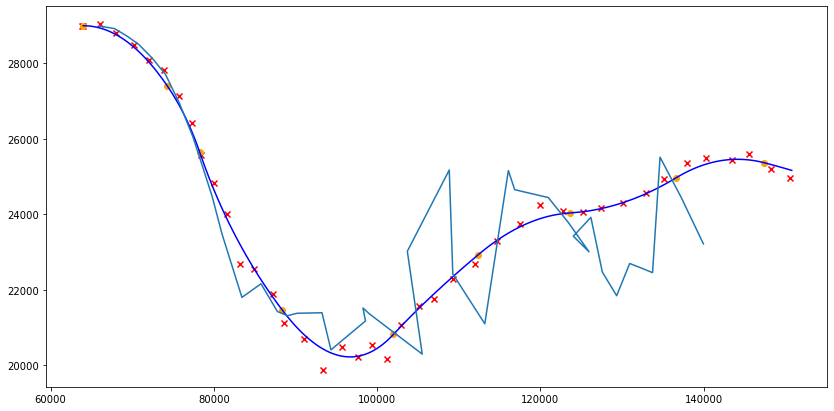

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(s_x, s_y, color='blue')
plt.scatter(x_obs, y_obs, marker='x', color='red')
plt.scatter(s_x_tau, s_y_tau, marker='o', color='orange')
plt.plot(expectation_x[1:], expectation_y[1:])

plt.savefig('pdp_pf_avg_outliers.png')

C:\Users\Chiara\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Chiara\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


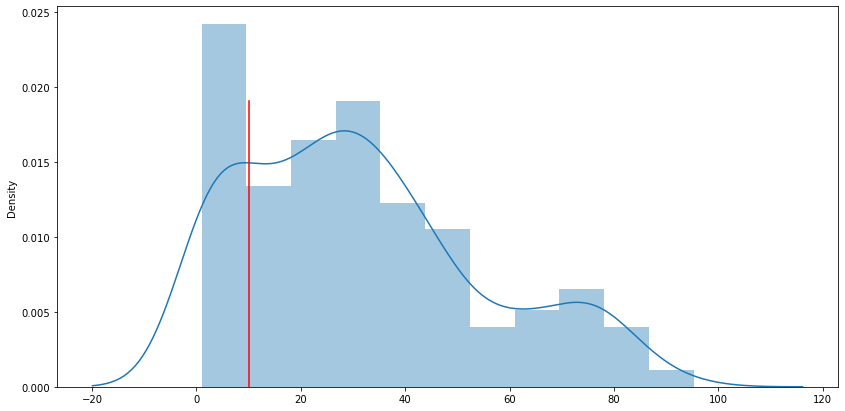

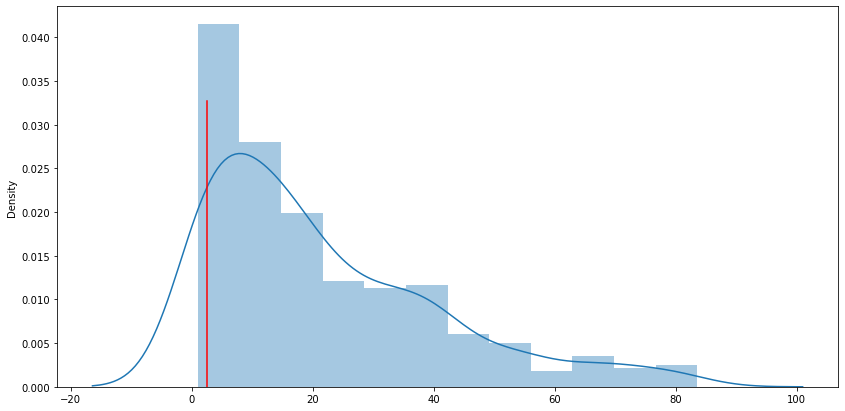

In [18]:
plt.figure(figsize=(14, 7))
sns.distplot(gamma_shape_values)
plt.axvline(10, 0, .75, color = 'r',label='Observation')

plt.figure(figsize=(14, 7))
sns.distplot(gamma_scale_values)
plt.axvline(2.5, 0, .75, color = 'r',label='Observation')

In [24]:
np.array(particles).shape

C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/3633695356.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(particles).shape


(10, 821)

In [28]:
np.array(particles[0]).shape

C:\Users\Chiara\AppData\Local\Temp/ipykernel_5456/2811606983.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(particles[0]).shape


(821,)

In [72]:
delta_taus = []

for i in range(10):
    for part in particles[i][41]:
        while part != None:
            tau = part.get_tau()
            parent = part.get_parent()
            if parent != None:
                tau_parent = parent.get_tau()
                delta_taus.append(int(tau - tau_parent))
            part = parent



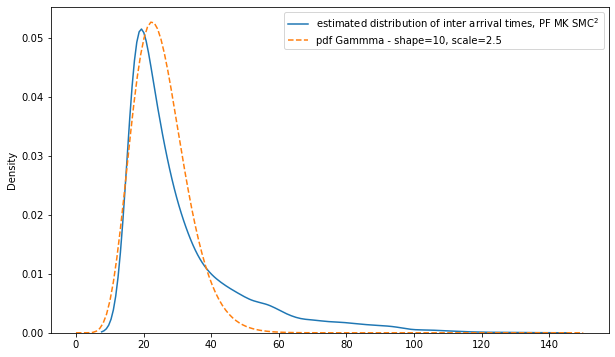

In [94]:
import scipy.stats as stats
from matplotlib.pyplot import figure 

figure(figsize=(10, 6))
sns.kdeplot(np.array(delta_taus)[np.array(delta_taus) >0], label = 'estimated distribution of inter arrival times, PF MK SMC$^2$')
x = np.linspace (0, 150, 150) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=10, scale=2.5)

#create plot of Gamma distribution
plt.plot(x, y, '--', label='pdf Gammma - shape=10, scale=2.5')
plt.legend()
#display plot
plt.show()

In [98]:
dist = np.array(delta_taus)[np.array(delta_taus) >0]

from numpy import savetxt

In [99]:
savetxt('smc2_mk.csv', dist, delimiter=',')